In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

In [27]:
date_range = pd.date_range(start='2023-01-01', end='2024-12-31', freq='D')
n_days = len(date_range)
seasonal_pattern = 100 * (1 + 0.3 * np.sin(2 * np.pi * np.arange(n_days) / 365))
trend = np.linspace(0, 50, n_days)
noise = np.random.normal(0, 20, n_days)
weekend_boost = np.where(pd.Series(date_range).dt.dayofweek.isin([5, 6]), 30, 0)

sales = np.maximum(0, seasonal_pattern + trend + noise + weekend_boost)
orders = np.random.poisson(sales / 20)
customers = np.random.poisson(orders * 0.7)

In [28]:
sample_data = pd.DataFrame({
    'date': date_range,
    'sales': sales,
    'orders': orders,
    'customers': customers
})

In [29]:
sample_data['date'] = pd.to_datetime(sample_data['date'])
sample_data = sample_data.set_index('date')

In [30]:
print(sample_data.head())
print(f"\nData shape: {sample_data.shape}")
print(f"Date range: {sample_data.index.min()} to {sample_data.index.max()}")

                 sales  orders  customers
date                                     
2023-01-01  139.934283       5          2
2023-01-02   97.819608       6         10
2023-01-03  114.123405       5          1
2023-01-04  132.214667       5          2
2023-01-05   97.654978       8          5

Data shape: (731, 3)
Date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00


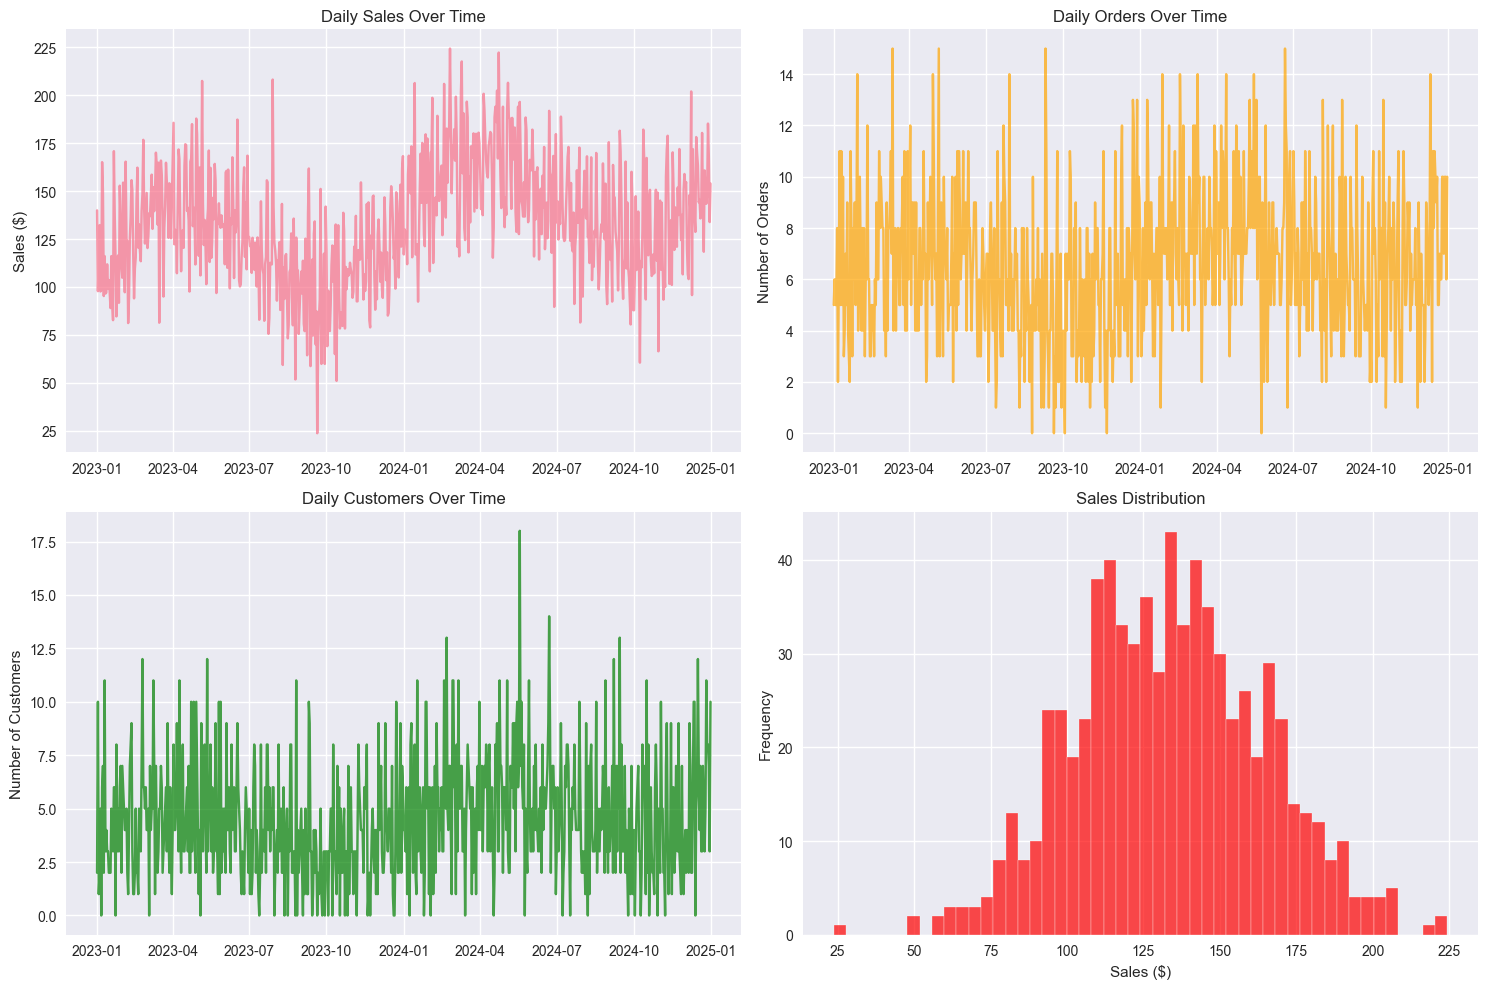

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(sample_data.index, sample_data['sales'], alpha=0.7)
axes[0, 0].set_title('Daily Sales Over Time')
axes[0, 0].set_ylabel('Sales ($)')

axes[0, 1].plot(sample_data.index, sample_data['orders'], alpha=0.7, color='orange')
axes[0, 1].set_title('Daily Orders Over Time')
axes[0, 1].set_ylabel('Number of Orders')

axes[1, 0].plot(sample_data.index, sample_data['customers'], alpha=0.7, color='green')
axes[1, 0].set_title('Daily Customers Over Time')
axes[1, 0].set_ylabel('Number of Customers')

axes[1, 1].hist(sample_data['sales'], bins=50, alpha=0.7, color='red')
axes[1, 1].set_title('Sales Distribution')
axes[1, 1].set_xlabel('Sales ($)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [32]:
def get_holiday_dates():
    current_year = datetime.now().year
    holidays = []

    for year in range(current_year - 1, current_year + 2):
        holidays.extend([
            datetime(year, 1, 1),
            datetime(year, 11, 24)
        ])

    return holidays

In [33]:
holidays = get_holiday_dates()
print("Detected Holidays:")
for holiday in holidays:
    print(f"  {holiday.strftime('%Y-%m-%d')}")

holiday_dates = pd.to_datetime(holidays)
sample_data['is_holiday'] = sample_data.index.normalize().isin(holiday_dates.normalize()).astype(int)

print(f"\nHoliday days in dataset: {sample_data['is_holiday'].sum()}")

Detected Holidays:
  2024-01-01
  2024-11-24
  2025-01-01
  2025-11-24
  2026-01-01
  2026-11-24

Holiday days in dataset: 2


C:\Users\ALEXANDER\AppData\Local\Temp\ipykernel_19064\1430750424.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([regular_sales, holiday_sales], labels=['Regular Days', 'Holidays'])


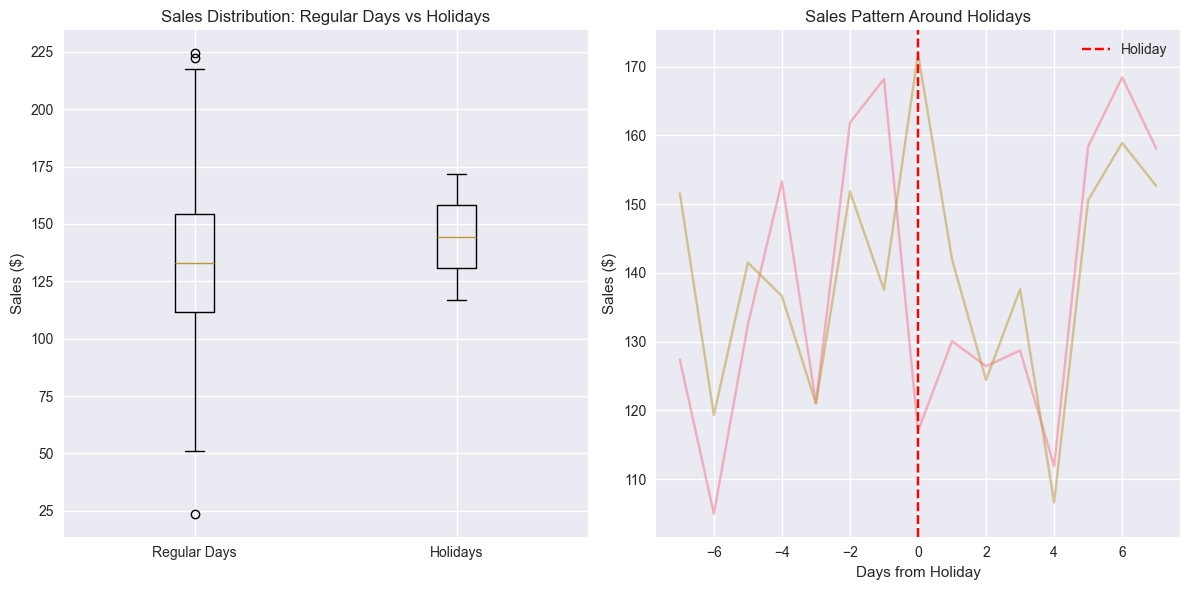

In [34]:
holiday_sales = sample_data[sample_data['is_holiday'] == 1]['sales']
regular_sales = sample_data[sample_data['is_holiday'] == 0]['sales']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot([regular_sales, holiday_sales], labels=['Regular Days', 'Holidays'])
plt.title('Sales Distribution: Regular Days vs Holidays')
plt.ylabel('Sales ($)')

plt.subplot(1, 2, 2)
for holiday in holiday_dates:
    if holiday in sample_data.index:
        window = sample_data.loc[holiday-pd.Timedelta(days=7):holiday+pd.Timedelta(days=7)]
        plt.plot(range(-7, 8), window['sales'], alpha=0.5)

plt.axvline(x=0, color='red', linestyle='--', label='Holiday')
plt.title('Sales Pattern Around Holidays')
plt.xlabel('Days from Holiday')
plt.ylabel('Sales ($)')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
def get_sales_data(data):

    try:
        df = data.copy()

        if len(df) > 1:
            full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
            df = df.reindex(full_range, fill_value=0)

        df['sales'] = pd.to_numeric(df['sales'], errors='coerce').fillna(0.0)
        df['orders'] = pd.to_numeric(df['orders'], errors='coerce').fillna(0).astype(int)
        df['customers'] = pd.to_numeric(df['customers'], errors='coerce').fillna(0).astype(int)

        return df

    except Exception as e:
        print(f"Error in data retrieval: {e}")
        today = datetime.now().date()
        fallback_df = pd.DataFrame({
            'sales': [0.0],
            'orders': [0],
            'customers': [0]
        }, index=[today])
        return fallback_df

processed_data = get_sales_data(sample_data)
print("Processed Data Info:")
print(f"Shape: {processed_data.shape}")
print(f"Missing values: {processed_data.isnull().sum().sum()}")
print(f"Data types:\n{processed_data.dtypes}")

Processed Data Info:
Shape: (731, 4)
Missing values: 0
Data types:
sales         float64
orders          int64
customers       int64
is_holiday      int64
dtype: object


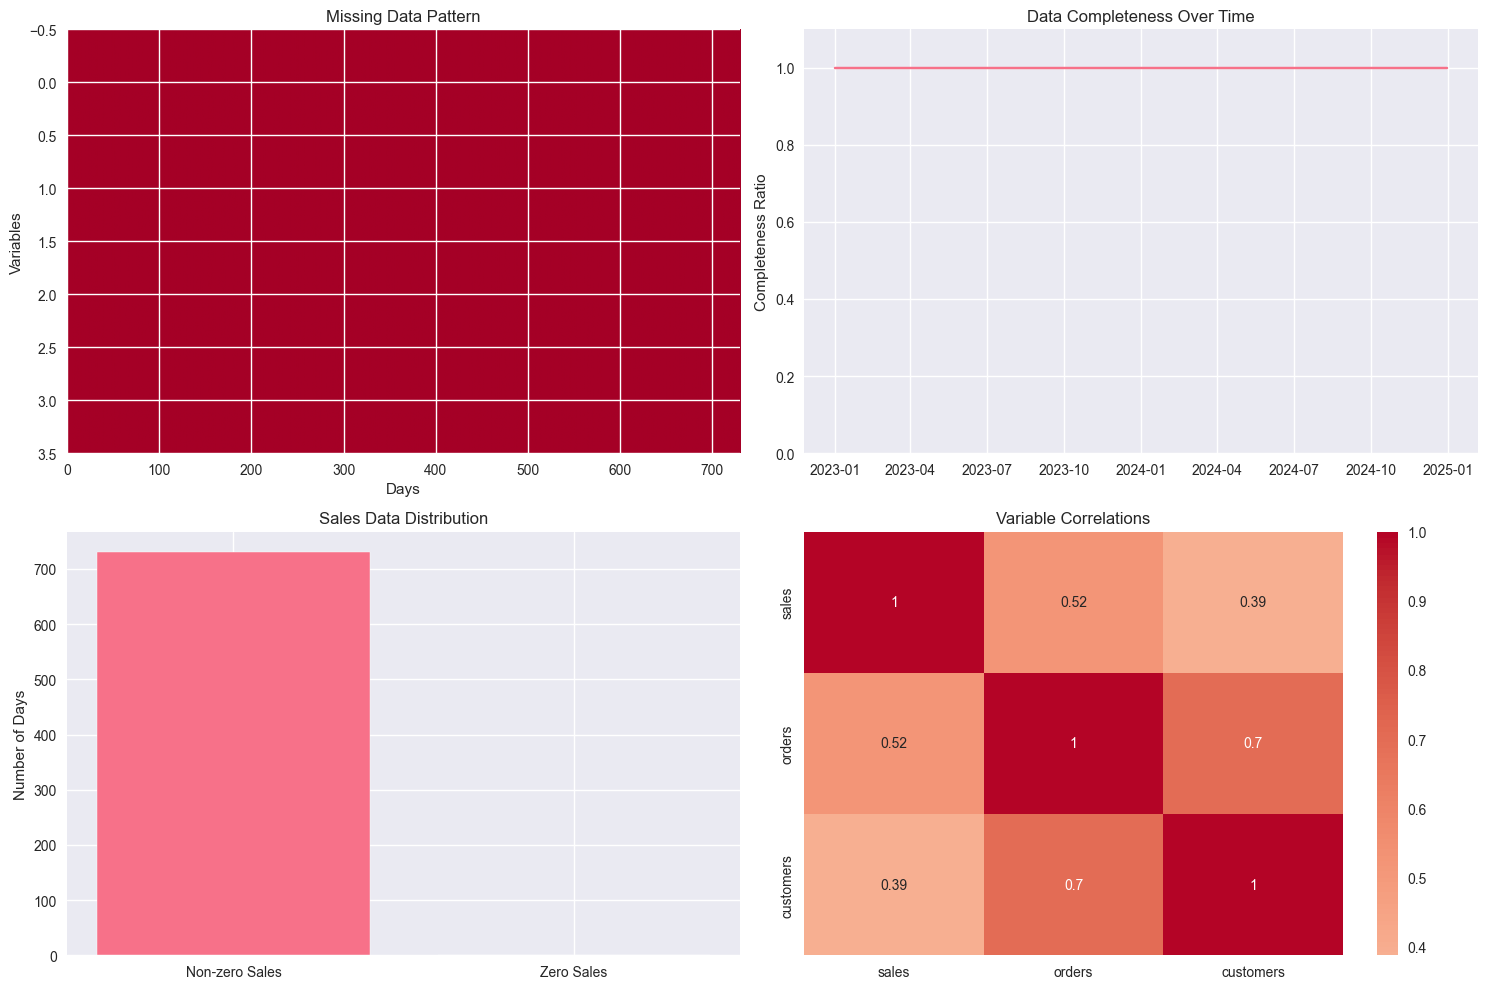

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].imshow(processed_data.isnull().T, cmap='RdYlBu', aspect='auto')
axes[0, 0].set_title('Missing Data Pattern')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Variables')

completeness = processed_data.notnull().mean(axis=1)
axes[0, 1].plot(processed_data.index, completeness)
axes[0, 1].set_title('Data Completeness Over Time')
axes[0, 1].set_ylabel('Completeness Ratio')
axes[0, 1].set_ylim(0, 1.1)

zero_sales_mask = processed_data['sales'] == 0
axes[1, 0].bar(['Non-zero Sales', 'Zero Sales'],
               [len(processed_data) - zero_sales_mask.sum(), zero_sales_mask.sum()])
axes[1, 0].set_title('Sales Data Distribution')
axes[1, 0].set_ylabel('Number of Days')

corr_matrix = processed_data[['sales', 'orders', 'customers']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1])
axes[1, 1].set_title('Variable Correlations')

plt.tight_layout()
plt.show()

In [37]:
def create_features(df):

    features = df.copy()

    features['year'] = features.index.year
    features['month'] = features.index.month
    features['day_of_week'] = features.index.dayofweek
    features['day_of_year'] = features.index.dayofyear
    features['quarter'] = features.index.quarter
    features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)

    season_map = {12: 0, 1: 0, 2: 0,
                  3: 1, 4: 1, 5: 1,
                  6: 2, 7: 2, 8: 2,
                  9: 3, 10: 3, 11: 3}
    features['season'] = features['month'].map(season_map)

    if 'is_holiday' not in features.columns:
        holiday_dates = pd.to_datetime(get_holiday_dates())
        features['is_holiday'] = features.index.normalize().isin(holiday_dates.normalize()).astype(int)

    if len(features) > 1:
        features['sales_lag_1'] = features['sales'].shift(1).fillna(0)
    else:
        features['sales_lag_1'] = 0

    if len(features) > 7:
        features['sales_lag_7'] = features['sales'].shift(7).fillna(0)
        features['sales_ma_7'] = features['sales'].rolling(7, min_periods=1).mean()
    else:
        features['sales_lag_7'] = 0
        features['sales_ma_7'] = features['sales']

    if len(features) > 30:
        features['sales_ma_30'] = features['sales'].rolling(30, min_periods=1).mean()
    else:
        features['sales_ma_30'] = features['sales']

    if len(features) > 7:
        sales_shifted = features['sales'].shift(7).fillna(0)
        features['sales_growth_7d'] = np.divide(
            features['sales'] - sales_shifted,
            sales_shifted,
            out=np.zeros_like(features['sales']),
            where=(sales_shifted != 0)
        )
        features['sales_growth_7d'] = np.where(
            np.isfinite(features['sales_growth_7d']),
            features['sales_growth_7d'],
            0
        )
    else:
        features['sales_growth_7d'] = 0

    features['trend'] = np.arange(len(features))

    features = features.replace([np.inf, -np.inf], 0)

    return features

features_data = create_features(processed_data)
print("Feature Engineering Results:")
print(f"Original columns: {list(processed_data.columns)}")
print(f"New columns: {list(features_data.columns)}")
print(f"Total features created: {len(features_data.columns) - len(processed_data.columns)}")

Feature Engineering Results:
Original columns: ['sales', 'orders', 'customers', 'is_holiday']
New columns: ['sales', 'orders', 'customers', 'is_holiday', 'year', 'month', 'day_of_week', 'day_of_year', 'quarter', 'is_weekend', 'season', 'sales_lag_1', 'sales_lag_7', 'sales_ma_7', 'sales_ma_30', 'sales_growth_7d', 'trend']
Total features created: 13


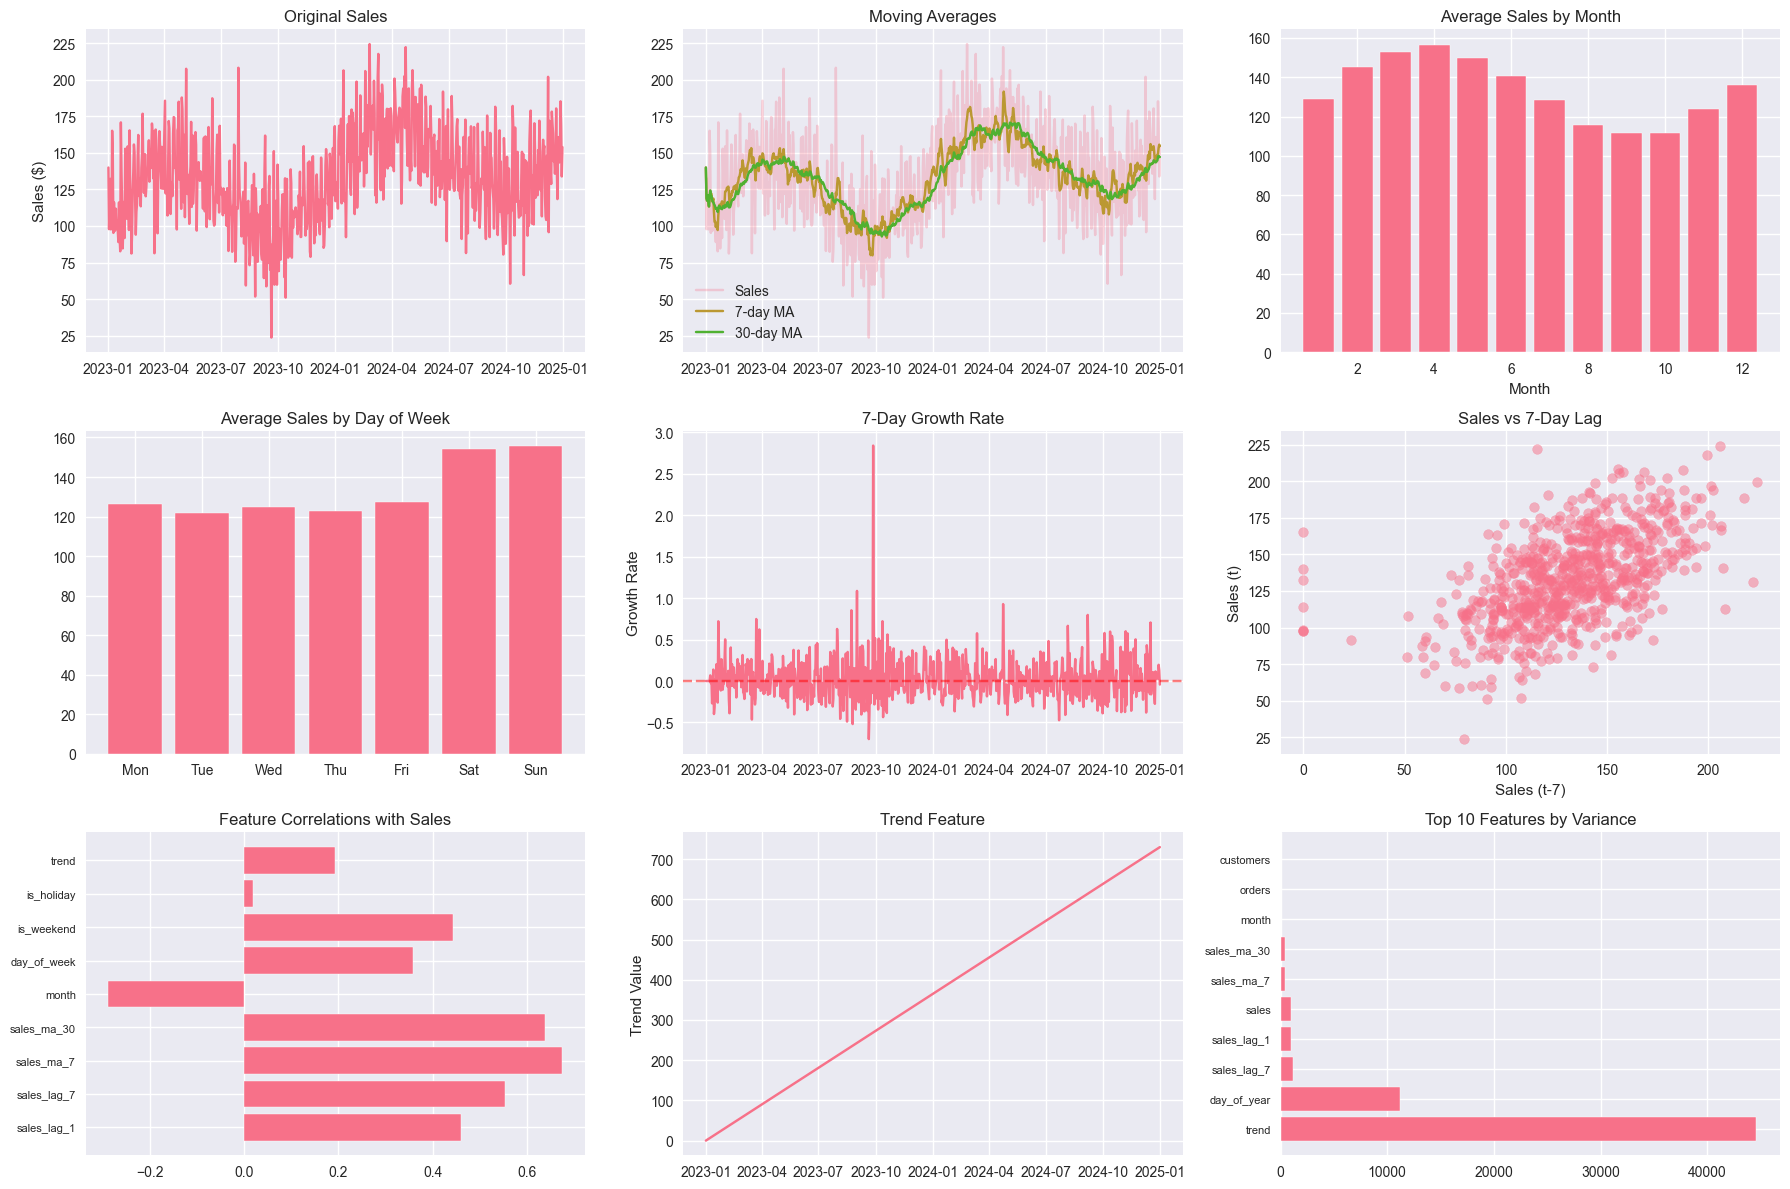

In [38]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

axes[0, 0].plot(features_data.index, features_data['sales'])
axes[0, 0].set_title('Original Sales')
axes[0, 0].set_ylabel('Sales ($)')

axes[0, 1].plot(features_data.index, features_data['sales'], alpha=0.3, label='Sales')
axes[0, 1].plot(features_data.index, features_data['sales_ma_7'], label='7-day MA')
axes[0, 1].plot(features_data.index, features_data['sales_ma_30'], label='30-day MA')
axes[0, 1].set_title('Moving Averages')
axes[0, 1].legend()

seasonal_avg = features_data.groupby('month')['sales'].mean()
axes[0, 2].bar(seasonal_avg.index, seasonal_avg.values)
axes[0, 2].set_title('Average Sales by Month')
axes[0, 2].set_xlabel('Month')

weekly_avg = features_data.groupby('day_of_week')['sales'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 0].bar(range(7), weekly_avg.values)
axes[1, 0].set_title('Average Sales by Day of Week')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(days)

axes[1, 1].plot(features_data.index, features_data['sales_growth_7d'])
axes[1, 1].set_title('7-Day Growth Rate')
axes[1, 1].set_ylabel('Growth Rate')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

axes[1, 2].scatter(features_data['sales_lag_7'], features_data['sales'], alpha=0.5)
axes[1, 2].set_title('Sales vs 7-Day Lag')
axes[1, 2].set_xlabel('Sales (t-7)')
axes[1, 2].set_ylabel('Sales (t)')

feature_cols = ['sales_lag_1', 'sales_lag_7', 'sales_ma_7', 'sales_ma_30',
                'month', 'day_of_week', 'is_weekend', 'is_holiday', 'trend']
correlations = features_data[['sales'] + feature_cols].corr()['sales'][1:]
axes[2, 0].barh(range(len(correlations)), correlations.values)
axes[2, 0].set_title('Feature Correlations with Sales')
axes[2, 0].set_yticks(range(len(correlations)))
axes[2, 0].set_yticklabels(correlations.index, fontsize=8)

axes[2, 1].plot(features_data.index, features_data['trend'])
axes[2, 1].set_title('Trend Feature')
axes[2, 1].set_ylabel('Trend Value')

numeric_features = features_data.select_dtypes(include=[np.number]).columns
feature_variance = features_data[numeric_features].var().sort_values(ascending=False)[:10]
axes[2, 2].barh(range(len(feature_variance)), feature_variance.values)
axes[2, 2].set_title('Top 10 Features by Variance')
axes[2, 2].set_yticks(range(len(feature_variance)))
axes[2, 2].set_yticklabels(feature_variance.index, fontsize=8)

plt.tight_layout()
plt.show()

In [39]:
def clean_data(df):

    df_clean = df.copy()

    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isna().any():
            median_val = df_clean[col].median()
            if pd.isna(median_val):
                median_val = 0
            df_clean[col] = df_clean[col].fillna(median_val)

    if len(df_clean) > 4:
        Q1 = df_clean['sales'].quantile(0.25)
        Q3 = df_clean['sales'].quantile(0.75)
        IQR = Q3 - Q1

        if IQR > 0:
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            print(f"Outlier bounds: {lower_bound:.2f} to {upper_bound:.2f}")
            outliers_before = ((df_clean['sales'] < lower_bound) |
                              (df_clean['sales'] > upper_bound)).sum()
            print(f"Outliers detected: {outliers_before}")

            df_clean['sales'] = df_clean['sales'].clip(lower_bound, upper_bound)

    df_clean = df_clean.replace([np.inf, -np.inf], 0)

    return df_clean

clean_data = clean_data(features_data)
print("Data Cleaning Results:")
print(f"Shape after cleaning: {clean_data.shape}")
print(f"Infinite values removed: {np.isinf(features_data.select_dtypes(include=[np.number])).sum().sum()}")

Outlier bounds: 47.80 to 218.64
Outliers detected: 3
Data Cleaning Results:
Shape after cleaning: (731, 17)
Infinite values removed: 0


C:\Users\ALEXANDER\AppData\Local\Temp\ipykernel_19064\4104478879.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_to_plot, labels=['Before', 'After'])


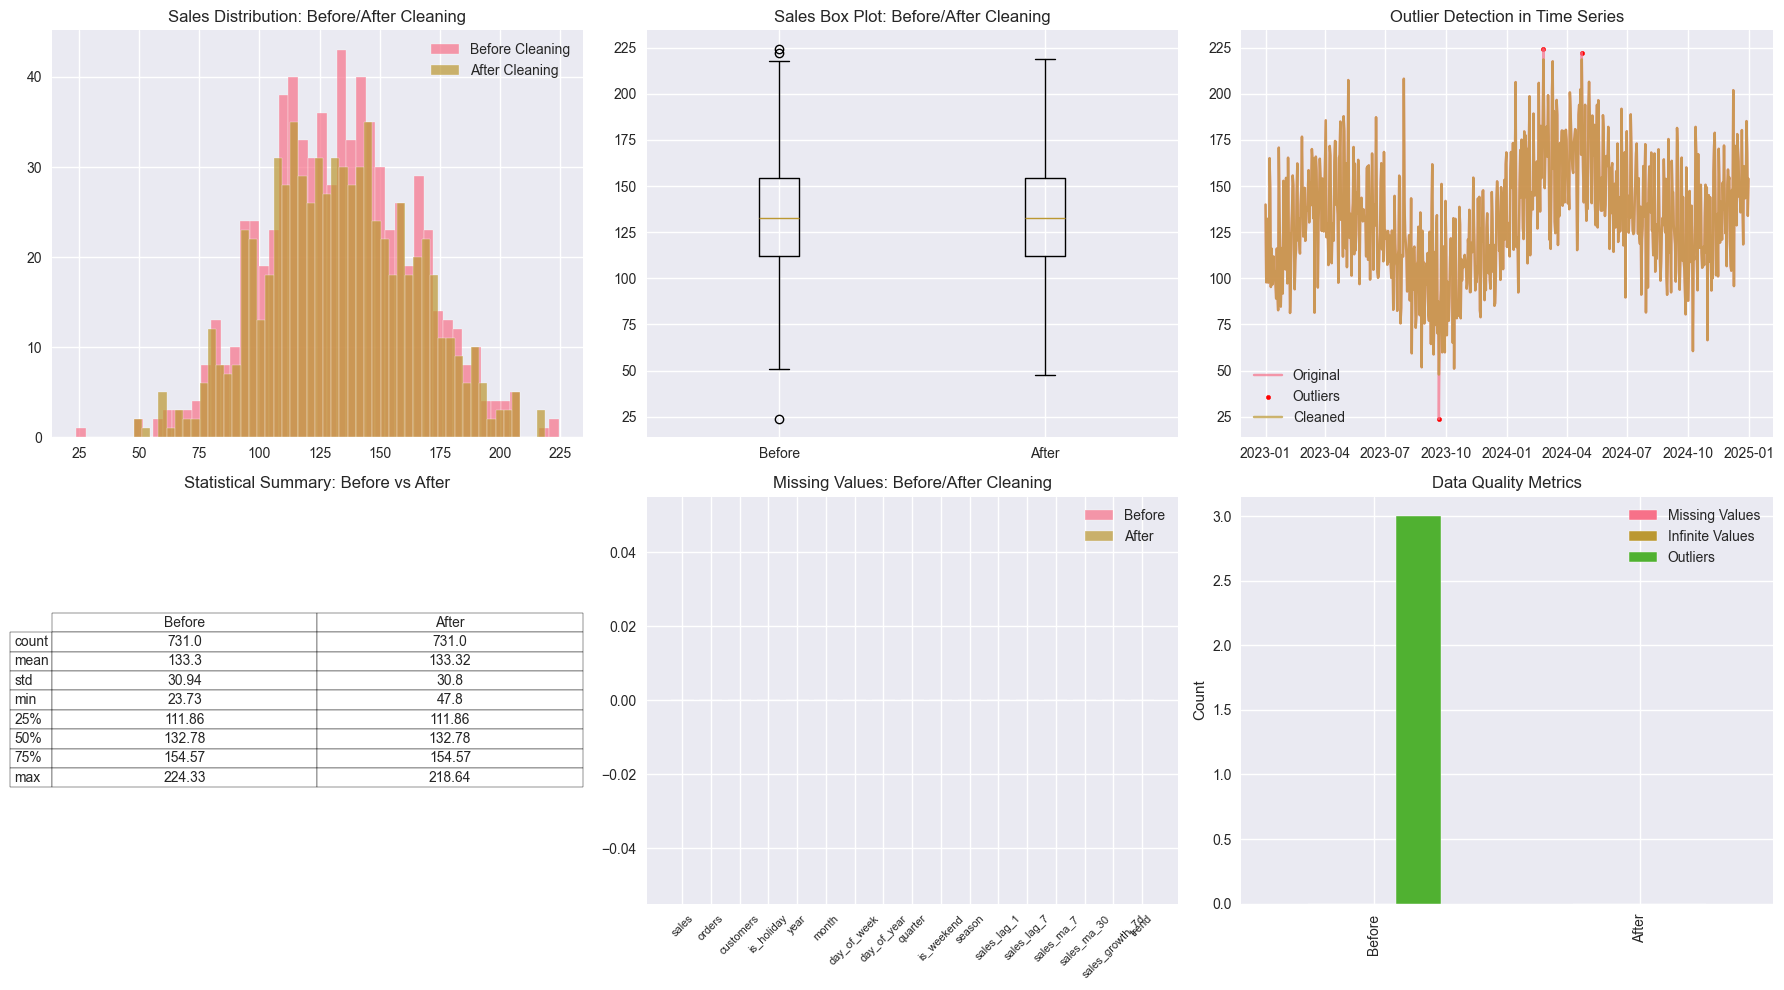

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

axes[0, 0].hist(features_data['sales'], bins=50, alpha=0.7, label='Before Cleaning')
axes[0, 0].hist(clean_data['sales'], bins=50, alpha=0.7, label='After Cleaning')
axes[0, 0].set_title('Sales Distribution: Before/After Cleaning')
axes[0, 0].legend()

data_to_plot = [features_data['sales'], clean_data['sales']]
axes[0, 1].boxplot(data_to_plot, labels=['Before', 'After'])
axes[0, 1].set_title('Sales Box Plot: Before/After Cleaning')

Q1 = features_data['sales'].quantile(0.25)
Q3 = features_data['sales'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((features_data['sales'] < lower_bound) |
                (features_data['sales'] > upper_bound))

axes[0, 2].plot(features_data.index, features_data['sales'], alpha=0.7, label='Original')
axes[0, 2].scatter(features_data.index[outlier_mask],
                   features_data['sales'][outlier_mask],
                   color='red', s=10, label='Outliers')
axes[0, 2].plot(clean_data.index, clean_data['sales'], alpha=0.7, label='Cleaned')
axes[0, 2].set_title('Outlier Detection in Time Series')
axes[0, 2].legend()

stats_before = features_data['sales'].describe()
stats_after = clean_data['sales'].describe()

stats_comparison = pd.DataFrame({'Before': stats_before, 'After': stats_after})
axes[1, 0].axis('tight')
axes[1, 0].axis('off')
table = axes[1, 0].table(cellText=stats_comparison.round(2).values,
                        rowLabels=stats_comparison.index,
                        colLabels=stats_comparison.columns,
                        cellLoc='center',
                        loc='center')
axes[1, 0].set_title('Statistical Summary: Before vs After')

missing_before = features_data.isnull().sum()
missing_after = clean_data.isnull().sum()
axes[1, 1].bar(range(len(missing_before)), missing_before.values, alpha=0.7, label='Before')
axes[1, 1].bar(range(len(missing_after)), missing_after.values, alpha=0.7, label='After')
axes[1, 1].set_title('Missing Values: Before/After Cleaning')
axes[1, 1].set_xticks(range(len(missing_before)))
axes[1, 1].set_xticklabels(missing_before.index, rotation=45, fontsize=8)
axes[1, 1].legend()

quality_metrics = {
    'Missing Values': [features_data.isnull().sum().sum(), clean_data.isnull().sum().sum()],
    'Infinite Values': [np.isinf(features_data.select_dtypes(include=[np.number])).sum().sum(),
                       np.isinf(clean_data.select_dtypes(include=[np.number])).sum().sum()],
    'Outliers': [outlier_mask.sum(), 0]
}

quality_df = pd.DataFrame(quality_metrics, index=['Before', 'After'])
quality_df.plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_title('Data Quality Metrics')
axes[1, 2].set_ylabel('Count')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

In [41]:
def prepare_training_data(df, test_size=0.2):

    if len(df) < 2:
        print("Warning: Insufficient data for train/test split")
        exclude_cols = ['sales', 'orders', 'customers']
        feature_cols = [col for col in df.columns if col not in exclude_cols]
        X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
        y = df['sales']
        return X, X, y, y

    exclude_cols = ['sales', 'orders', 'customers']
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    X = df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    y = df['sales']

    split_idx = max(1, int(len(df) * (1 - test_size)))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    if len(X_test) == 0:
        X_test = X_train.iloc[-1:].copy()
        y_test = y_train.iloc[-1:].copy()

    return X_train, X_test, y_train, y_test

In [42]:
def train_models(X_train, y_train, X_test, y_test):
    if len(X_train) == 0 or y_train.nunique() <= 1:
        print("Warning: Insufficient training data or no variance in target")
        return {}

    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0)
    }

    results = {}

    scaler = StandardScaler()
    scaler.fit(X_train)

    if hasattr(scaler, "scale_"):
        zero_scale_mask = (scaler.scale_ == 0)
        if zero_scale_mask.any():
            scaler.scale_[zero_scale_mask] = 1.0

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    n_features = X_train_scaled.shape[1]
    n_samples = len(X_train_scaled)
    k = min(10, n_features, max(1, n_samples - 1))

    feature_selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = feature_selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = feature_selector.transform(X_test_scaled)

    for name, model in models.items():
        try:
            model.fit(X_train_selected, y_train)

            train_pred = model.predict(X_train_selected)
            test_pred = model.predict(X_test_selected)

            train_mae = mean_absolute_error(y_train, train_pred)
            test_mae = mean_absolute_error(y_test, test_pred)
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

            results[name] = {
                'model': model,
                'train_mae': train_mae,
                'test_mae': test_mae,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_predictions': train_pred,
                'test_predictions': test_pred
            }

        except Exception as e:
            print(f"Error training {name}: {e}")
            continue

    return results, scaler, feature_selector

In [43]:
X_train, X_test, y_train, y_test = prepare_training_data(clean_data)
model_results, scaler, selector = train_models(X_train, y_train, X_test, y_test)

print("Model Training Results:")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Features used: {X_train.columns.tolist()[:10]}...")

Model Training Results:
Training data shape: (584, 14)
Test data shape: (147, 14)
Features used: ['is_holiday', 'year', 'month', 'day_of_week', 'day_of_year', 'quarter', 'is_weekend', 'season', 'sales_lag_1', 'sales_lag_7']...


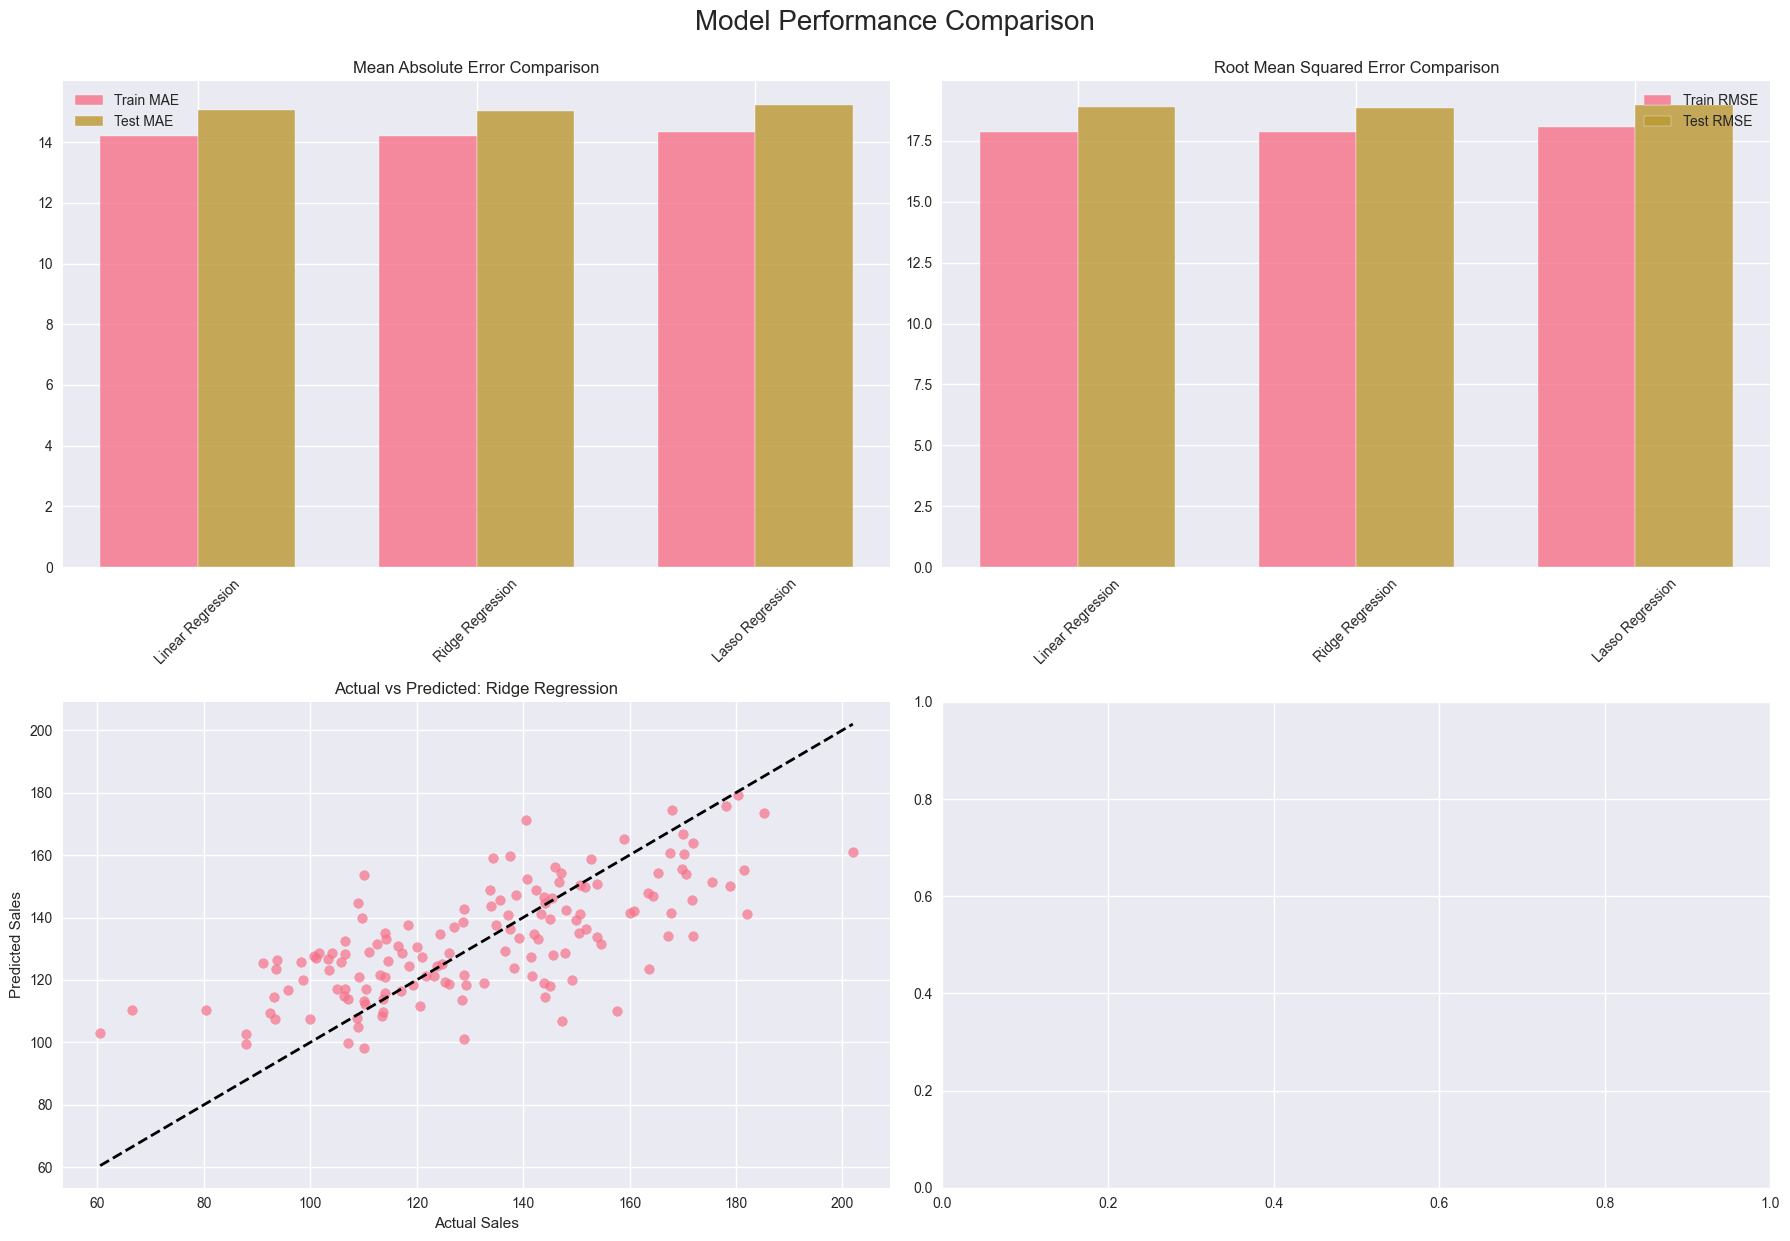

In [44]:
if model_results:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    models = list(model_results.keys())
    train_maes = [model_results[m]['train_mae'] for m in models]
    test_maes = [model_results[m]['test_mae'] for m in models]
    train_rmses = [model_results[m]['train_rmse'] for m in models]
    test_rmses = [model_results[m]['test_rmse'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    axes[0, 0].bar(x - width/2, train_maes, width, label='Train MAE', alpha=0.8)
    axes[0, 0].bar(x + width/2, test_maes, width, label='Test MAE', alpha=0.8)
    axes[0, 0].set_title('Mean Absolute Error Comparison')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(models, rotation=45)
    axes[0, 0].legend()

    axes[0, 1].bar(x - width/2, train_rmses, width, label='Train RMSE', alpha=0.8)
    axes[0, 1].bar(x + width/2, test_rmses, width, label='Test RMSE', alpha=0.8)
    axes[0, 1].set_title('Root Mean Squared Error Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(models, rotation=45)
    axes[0, 1].legend()

    best_model_name = min(models, key=lambda m: model_results[m]['test_mae'])
    best_model = model_results[best_model_name]

    axes[1, 0].scatter(y_test, best_model['test_predictions'], alpha=0.7)
    axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[1, 0].set_title(f'Actual vs Predicted: {best_model_name}')
    axes[1, 0].set_xlabel('Actual Sales')
    axes[1, 0].set_ylabel('Predicted Sales')


    plt.tight_layout()
    plt.suptitle("Model Performance Comparison", fontsize=20, y=1.03)
    plt.show()